# HW5: Regularized Linear Regression and Bias v.s. Variance

In this exercise, you will implement regularized linear regression and use it to study models with dierent bias-variance properties. Before starting on the programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics. 

To get started with the exercise, you will need to download the starter code and unzip its contents to the directory where you wish to complete the exercise. If needed, use the cd command in Octave/MATLAB to change to this directory before starting this exercise.

You can also finnd instructions for installing Octave/MATLAB in the "Environment Setup Instructions" of the course website.

In [87]:
import itertools as it
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.misc
import scipy.optimize as op
import scipy.io
import random
from IPython.display import display, Math, Latex

# set path
import os
os.chdir('%s/courses/coursera_ml008/hw5' % os.getenv('DST'))
print(os.getcwd())

# printing options 
np.set_printoptions(linewidth=250)
np.set_printoptions(precision=3)

# plotting options
%matplotlib inline
plt.rc('font'  , size=18)
plt.rc('figure', figsize=(10, 8))
plt.rc('axes'  , labelsize=22)
plt.rc('legend', fontsize=16)
plt.rc('figure', figsize=(10, 8))

/Users/rwk7t/Development/dst/courses/coursera_ml008/hw5


## 1 Regularized Linear Regression

In the first half of the exercise, you will implement regularized linear regression to predict the amount of water 
flowing out of a dam using the change of water level in a reservoir. In the next half, you will go through some diagnostics of debugging learning algorithms and examine the effects of bias v.s. variance.

### 1.1 Visualing the dataset

We will begin by visualizing the dataset containing historical records on the change in the water level, $x$, and the amount of water flowing out of the dam, $y$.

This dataset is divided into three parts:
 * A training set that your model will learn on: $X$, $y$
 * A cross validation set for determining the regularization parameter: `Xval`, `yval`
 * A test set for evaluating performance. These are "unseen" examples which your model did not see during training: `Xtest`, `ytest`
 
The next step of ex5.m will plot the training data (Figure 1). In the following parts, you will implement linear regression and use that to fit a straight line to the data and plot learning curves. Following that, you will
implement polynomial regression to find a better fit to the data.

<img src="fig1.png" width=500/>

In [88]:
ex5data1 = scipy.io.loadmat('ex5data1.mat')
X_train = ex5data1['X'   ]
X_val   = ex5data1['Xval']
X_test  = ex5data1['Xtest']

y_train = ex5data1['y'   ]
y_val   = ex5data1['yval']
y_test  = ex5data1['ytest']

In [89]:
X_train.shape, X_val.shape, X_test.shape

((12, 1), (21, 1), (21, 1))

In [90]:
y_train.shape, y_val.shape, y_test.shape

((12, 1), (21, 1), (21, 1))

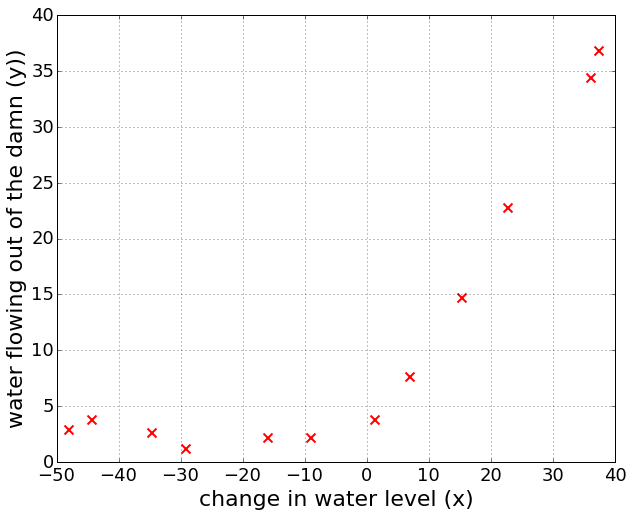

In [91]:
plt.scatter(X_train, y_train, color='r', marker='x', s=80, linewidth=2)
plt.xlabel("change in water level (x)")
plt.ylabel("water flowing out of the damn (y))")
plt.axis([-50, 40, 0, 40])
plt.grid()
plt.show()

## 1.2 Regularized linear regression cost function

Recall that regularized linear regression has the following cost function:
    
\begin{align}
J(\theta) = \frac{1}{2m}\left( \sum_{i=1}^m \left[ h_{\theta}(x^{(i)} - y^{(i)}\right]^2 \right)
- \frac{\lambda}{2m}\left( \sum_{j=1}^n \theta_j^2 \right)
\end{align}

where $\lambda$ is a regularization parameter which controls the degree of regularization (thus, help preventing overfitting). The regularization term puts a penalty on the overal cost J. As the magnitudes of the model parameters $\theta_j$ increase, the penalty increases as well. Note that you should not regularize the $\theta_0$ term.

You should now complete the code in the file linearRegCostFunction.m. Your task is to write a function to calculate the regularized linear regression cost function. If possible, try to vectorize your code and avoid writing loops. When you are finished, the next part of ex5.m will run your cost function using theta initialized at [1; 1]. You should expect to see an output of 303.993.

In [92]:
def prepend_ones(X):
    X    = np.asmatrix(X)
    m, n = X.shape
    return np.concatenate((np.ones((m,1)), X), axis=1)


In [93]:
def h(theta, X):
    theta = np.asmatrix(theta)
    X     = np.asmatrix(X)
    return X*theta.T

In [94]:
def cost(theta, X, y, lambda_param=0.0):
    theta   = np.asmatrix(theta)
    m       = len(X)
    X       = prepend_ones(np.asmatrix(X))
    y       = np.asmatrix(y)
    h_value = h(theta,X)
    
    J  = (1.0/(2*m)) * np.sum(np.power(h_value - y,2))
    J += (lambda_param/(2*m)) * np.sum(np.power(theta[...,1:],2))
    return J

In [95]:
cost(theta=np.array([1,1]), X=X_train, y=y_train, lambda_param=1.0)

303.99319222026429

### 1.3 Regularized linear regression gradient

Correspondingly, the partial derivative of regularized linear regression's cost for $\theta_j# is defined as

\begin{align}
\frac{\partial J(\theta)}{\partial \theta_j} 
&= \frac{1}{m} \sum_{i=1}^m \left( h_{\theta}(x^{(i)} - y^{(i)}\right)x_j^{(i)}
& \text{for} \space j = 0 \\
\frac{\partial J(\theta)}{\partial \theta_j} 
&= \left( \frac{1}{m} \sum_{i=1}^m \left( h_{\theta}(x^{(i)} - y^{(i)}\right)x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j
& \text{for} \space j \neq 0
\end{align}

In `linearRegCostFunction.m`, add code to calculate the gradient, returning it in the variable grad. When you are finished, the next part of ex5.m will run your gradient function using theta initialized at [1; 1]. You should expect to see a gradient of [-15.30; 598.250].

In [96]:
def grad(theta, X, y, lambda_param=0.0):
    theta   = np.asmatrix(theta)
    X       = prepend_ones(np.asmatrix(X))
    m, n    = X.shape
    y       = np.asmatrix(y)
    beta    = h(theta,X) - y
    result  = (1.0/m)*beta.T*X
    
    # regularization
    result[...,1:] += (lambda_param/m)*theta[...,1:]
    
    result = np.asarray(result).reshape(n)
    return result

In [97]:
grad(theta=np.array([1,1]), X=X_train, y=y_train, lambda_param=1.0)

array([ -15.303,  598.251])

### 1.4 Fitting Linear Regression

Once your cost function and gradient are working correctly, the next part of ex5.m will run the code in `trainLinearReg.m` to compute the optimal values of $\theta#. This training function uses `fmincg` to optimize the cost function.

In this part, we set regularization parameter #\lambda# to zero. Because our current implementation of linear regression is trying to fit a 2-dimensional $\theta$, regularization will not be incredibly helpful for a $\theta# of such low dimension. In the later parts of the exercise, you will be using polynomial regression with regularization.

Finally, the ex5.m script should also plot the best fot line, resulting in an image similar to Figure 2. The best fit line tells us that the model is not a good fit to the data because the data has a non-linear pattern. While visualizing the best fit as shown is one possible way to debug your learning algorithm, it is not always easy to visualize the data and model. In the next section, you will implement a function to generate learning curves that can help you debug your learning algorithm even if it is not easy to visualize the data.

<img src="fig2.png" width=500/>

In [98]:
theta0       = np.array([0,0])
lambda_param = 0.0
theta0, lambda_param

(array([0, 0]), 0.0)

In [99]:
theta0.shape

(2,)

In [100]:
op_result = op.minimize(
    fun=cost, 
    jac=grad, 
    x0=theta0, 
    args=(X_train, y_train, lambda_param), 
    method='CG', 
    options={'maxiter': 200, 'disp':True}
)

Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5


In [101]:
op_result

  status: 0
 success: True
    njev: 5
    nfev: 5
     fun: 22.373906495108905
       x: array([ 13.088,   0.368])
 message: 'Optimization terminated successfully.'
     jac: array([  6.055e-14,  -6.894e-12])
     nit: 2

In [102]:
theta_fit = op_result.x

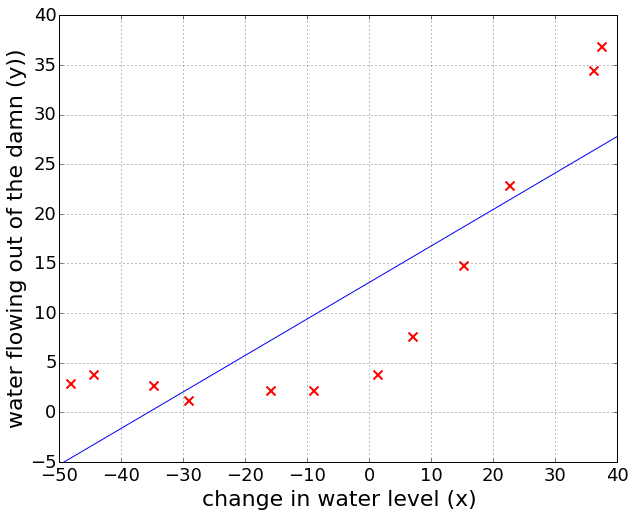

In [103]:
x   = np.linspace(-50,40,100)
fit = theta_fit[0]+theta_fit[1]*x

plt.scatter(X_train, y_train, color='r', marker='x', s=80, linewidth=2)
plt.plot(x, fit, 'b')
plt.xlabel("change in water level (x)")
plt.ylabel("water flowing out of the damn (y))")
plt.axis([-50, 40, -5, 40])
plt.grid()
plt.show()

## 2. Bias-variance

An important concept in machine learning is the bias-variance tradeoff. Mod- els with high bias are not complex enough for the data and tend to underfit, while models with high variance overfit to the training data.

In this part of the exercise, you will plot training and test errors on a learning curve to diagnose bias-variance problems.

### 2.1 Learning Curves

You will now implement code to generate the learning curves that will be useful in debugging learning algorithms. Recall that a learning curve plots training and cross validation error as a function of training set size. Your job is to fill in `learningCurve.m` so that it returns a vector of errors for the training set and cross validation set.

To plot the learning curve, we need a training and cross validation set error for different training set sizes. To obtain different training set sizes, you should use different subsets of the original training set $X$. Specifically, for a training set size of $i$, you should use the first i examples (i.e., `X(1:i,:)` and `y(1:i))`.

You can use the `trainLinearReg` function to find the $\theta$ parameters. Note that the `lambda` is passed as a parameter to the `learningCurve` function. After learning the $\theta$ parameters, you should compute the error on the training and cross validation sets. Recall that the training error for a dataset is defined as

\begin{align}
J_{train}(\theta) = \frac{1}{2m}\left[\sum_{i=1}^{m}\left(h_{\theta}(x^{(i)}) - y^{(i)}\right)^2\right]
\end{align}

In particular, note that the training error does not include the regularization term. One way to compute the training error is to use your existing cost function and set $\lambda$ to 0 only when using it to compute the training error and cross validation error. When you are computing the training set error, make sure you compute it on the training subset (i.e., `X(1:n,:)` and `y(1:n)`) (instead of the entire training set). However, for the cross validation error, you should compute it over the entire cross validation set. You should store the computed errors in the vectors `error_train` and `error_val`.

When you are finished, ex5.m wil print the learning curves and produce a plot similar to Figure 3.

<img src="fig3.png" width=500/>

In Figure 3, you can observe that both the train error and cross validation error are high when the number of training examples is increased. This reflects a high bias problem in the model – the linear regression model is too simple and is unable to fit our dataset well. In the next section, you will implement polynomial regression to fit a better model for this dataset.

In [104]:
def train_linreg(X, y, lambda_param=0.0, disp=False):
   
    theta0 = np.zeros((X.shape[1]+1,))

    op_result = op.minimize(
        fun=cost, 
        jac=grad, 
        x0=theta0, 
        args=(X, y, lambda_param),
        method='SLSQP',
#         method='CG', 
        options={'maxiter': 200, 'disp': disp}
    )

    theta = op_result.x
    return theta

In [105]:
def learning_err(X_train, y_train, X_val, y_val, lambda_param=0.0):
    m, n         = X_train.shape
    err_train    = np.zeros((m+1,))
    err_val      = np.zeros((m+1,))

    for i in np.arange(1,m+1):
        X = X_train[:i]
        y = y_train[:i]
        
        theta = train_linreg(X, y, lambda_param=lambda_param)

        err_train[i] = cost(theta, X    , y    , lambda_param=0.0)
        err_val[i]   = cost(theta, X_val, y_val, lambda_param=0.0)

    return err_train, err_val

In [106]:
err_train, err_val = learning_err(X_train, y_train, X_val, y_val, lambda_param)

In [107]:
err_train.shape, err_val.shape

((13,), (13,))

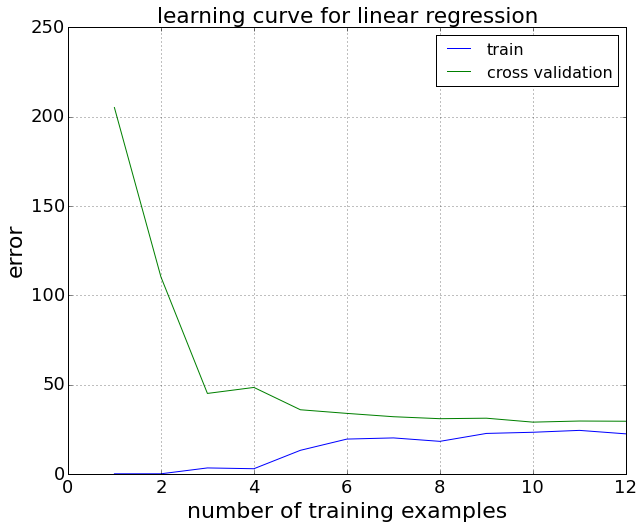

In [108]:
x = np.arange(err_train.size)
plt.plot(x[1:], err_train[1:], x[1:], err_val[1:])
plt.legend(['train', 'cross validation'])
plt.title('learning curve for linear regression')
plt.xlabel("number of training examples")
plt.ylabel("error")
plt.grid()

## 3. Polynomial Regression

The problem with our linear model was that it was too simple for the data and resulted in underfitting (high bias). In this part of the exercise, you will address this problem by adding more features.
For use polynomial regression, our hypothesis has the form:

\begin{align}
h_{\theta}(x) &= \theta_0 + \theta_1*\text{(water level)} + \theta_2*\text{(water level)}^2 + \dots + + \theta_p*\text{(water level)}^p \\
              &= \theta_0 + \theta_1*x_1 + \theta_2*x_2 + \dots + x_p
\end{align}

Notice that by defining $x_1 =text{(water level)}$, $x_2 = text{(water level)^2}$, ... , $x_p = text{(water level)^p}$, we obtain a linear regression model where the features are the various powers of the original value (water level).

Now, you will add more features using the higher powers of the existing feature $x$ in the dataset. Your task in this part is to complete the code in `polyFeatures.m` so that the function maps the original training set $X$ of size `m × 1` into its higher powers. Specifically, when a training set X of size `m × 1` is passed into the function, the function should return a `m×p` matrix $X$ poly, where column 1 holds the original values of `X`, column 2 holds the values of $X^2$, column 3 holds the values of $X^3$, and so on. Note that you don’t have to account for the zero-eth power in this function.

Now you have a function that will map features to a higher dimension, and Part 6 of ex5.m will apply it to the training set, the test set, and the cross validation set (which you haven’t used yet).

In [109]:
def poly_features(X, p):
    m      = X.shape[0]
    X_poly = np.empty((m, p))
    for n in np.arange(p):
        X_poly[...,n] = np.array(X**(n+1)).reshape(m,)
    return X_poly

In [110]:
poly_features(np.ones((5,1))*2, 8)

array([[   2.,    4.,    8.,   16.,   32.,   64.,  128.,  256.],
       [   2.,    4.,    8.,   16.,   32.,   64.,  128.,  256.],
       [   2.,    4.,    8.,   16.,   32.,   64.,  128.,  256.],
       [   2.,    4.,    8.,   16.,   32.,   64.,  128.,  256.],
       [   2.,    4.,    8.,   16.,   32.,   64.,  128.,  256.]])

In [111]:
poly_features(X_train, 3)

array([[ -1.594e+01,   2.540e+02,  -4.048e+03],
       [ -2.915e+01,   8.499e+02,  -2.478e+04],
       [  3.619e+01,   1.310e+03,   4.740e+04],
       [  3.749e+01,   1.406e+03,   5.270e+04],
       [ -4.806e+01,   2.310e+03,  -1.110e+05],
       [ -8.941e+00,   7.995e+01,  -7.149e+02],
       [  1.531e+01,   2.343e+02,   3.587e+03],
       [ -3.471e+01,   1.205e+03,  -4.180e+04],
       [  1.389e+00,   1.930e+00,   2.681e+00],
       [ -4.438e+01,   1.970e+03,  -8.743e+04],
       [  7.014e+00,   4.919e+01,   3.450e+02],
       [  2.276e+01,   5.181e+02,   1.179e+04]])

### 3.1 Learning Polynomial Regression

After you have completed `polyFeatures.m`, the ex5.m script will proceed to train polynomial regression using your linear regression cost function.

Keep in mind that even though we have polynomial terms in our feature vector, we are still solving a linear regression optimization problem. The polynomial terms have simply turned into features that we can use for linear regression. We are using the same cost function and gradient that you wrote for the earlier part of this exercise.

For this part of the exercise, you will be using a polynomial of degree 8. It turns out that if we run the training directly on the projected data, will not work well as the features would be badly scaled (e.g., an example with
$x = 40$ will now have a feature $x^8 = 40^8 = 6.5 \times 10^{12}$). Therefore, you will need to use feature normalization.

Before learning the parameters $\theta$ for the polynomial regression, `ex5.m` will first call `featureNormalize` and normalize the features of the training set, storing the `mu`, `sigma` parameters separately. We have already implemented this function for you and it is the same function from the first exercise.

After learning the parameters $\theta$, you should see two plots (Figure 4,5) generated for polynomial regression with $\lambda = 0$.

<img src="fig4.png" width=500/>
<img src="fig5.png" width=500/>

From Figure 4, you should see that the polynomial fit is able to follow the datapoints very well - thus, obtaining a low training error. However, the polynomial fit is very complex and even drops off at the extremes. This is an indicator that the polynomial regression model is overfitting the training data and will not generalize well.

To better understand the problems with the unregularized ($\lambda = 0$) model, you can see that the learning curve (Figure 5) shows the same effect where the low training error is low, but the cross validation error is high. There is a gap between the training and cross validation errors, indicating a high variance problem.

One way to combat the overtting (high-variance) problem is to add regularization to the model. In the next section, you will get to try different fit parameters to see how regularization can lead to a better model.

In [112]:
def normalize_features(X):
    mu    = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_norm = (X - mu)/sigma
    return (X_norm, mu, sigma)

In [113]:
normalize_features(poly_features(X_train, 3))

(array([[ -3.782e-01,  -7.887e-01,   1.903e-01],
        [ -8.389e-01,   1.314e-03,  -2.590e-01],
        [  1.439e+00,   6.108e-01,   1.305e+00],
        [  1.484e+00,   7.381e-01,   1.420e+00],
        [ -1.498e+00,   1.936e+00,  -2.128e+00],
        [ -1.344e-01,  -1.019e+00,   2.626e-01],
        [  7.108e-01,  -8.147e-01,   3.558e-01],
        [ -1.032e+00,   4.714e-01,  -6.280e-01],
        [  2.257e-01,  -1.123e+00,   2.781e-01],
        [ -1.370e+00,   1.486e+00,  -1.617e+00],
        [  4.217e-01,  -1.060e+00,   2.855e-01],
        [  9.707e-01,  -4.385e-01,   5.337e-01]]),
 array([ -5.085e+00,   8.489e+02,  -1.283e+04]),
 array([  2.869e+01,   7.543e+02,   4.614e+04]))

In [114]:
degree = 8
X_poly_train, mu_poly_train, sigma_poly_train = normalize_features(poly_features(X_train, degree))
X_poly_val  , mu_poly_val  , sigma_poly_val   = normalize_features(poly_features(X_val  , degree))
X_poly_test , mu_poly_test , sigma_poly_test  = normalize_features(poly_features(X_test , degree))

In [115]:
theta_poly_fit = train_linreg(X_poly_train, y_train, lambda_param=0.0, disp=True)
theta_poly_fit

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0438007203417
            Iterations: 45
            Function evaluations: 47
            Gradient evaluations: 45


array([ 11.218,  10.374,  20.341,  17.014, -40.624, -42.223,  37.989,  34.268,  -4.199])

In [116]:
theta_poly_fit

array([ 11.218,  10.374,  20.341,  17.014, -40.624, -42.223,  37.989,  34.268,  -4.199])

In [117]:
def plot_fit(x, mu, sigma, theta, p):
    from numpy import c_
    X_poly = poly_features(x, p)
    X_poly = (X_poly - mu) / sigma
    X_poly = c_[np.ones((x.shape[0], 1)), X_poly]
    plt.plot(x, X_poly.dot(theta), linestyle='--', linewidth=3 )

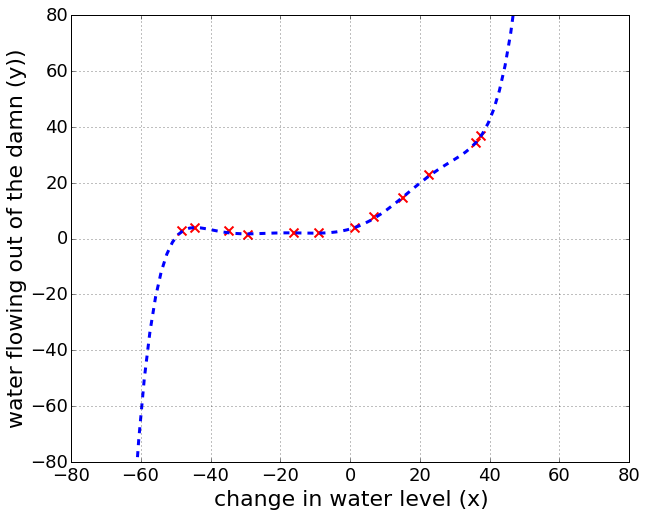

In [118]:
x   = np.linspace(-80,80,100)
p   = np.poly1d(theta_poly_fit[::-1])
plt.scatter(X_train, y_train, color='r', marker='x', s=80, linewidth=2)
plot_fit(x, mu_poly_train, sigma_poly_train, theta_poly_fit, degree)
plt.xlabel("change in water level (x)")
plt.ylabel("water flowing out of the damn (y))")
plt.axis([-80, 80, -80, 80])
plt.grid()
plt.show()

In [119]:
err_train, err_val = learning_err(X_poly_train, y_train, X_poly_val, y_val, lambda_param)

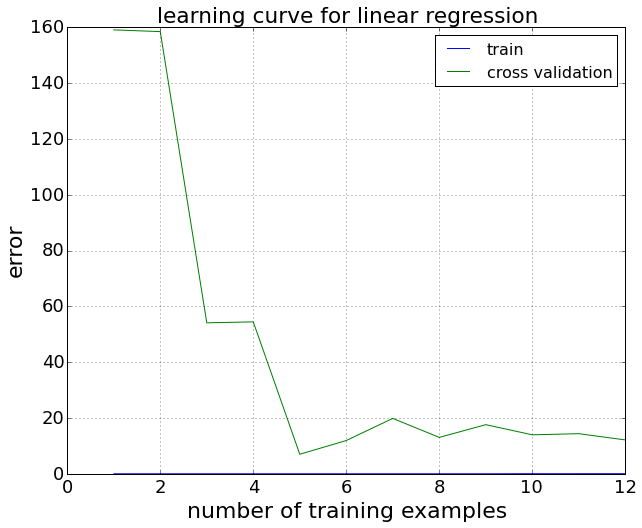

In [120]:
x = np.arange(err_train.size)
plt.plot(x[1:], err_train[1:], x[1:], err_val[1:])
plt.legend(['train', 'cross validation'])
plt.title('learning curve for linear regression')
plt.xlabel("number of training examples")
plt.ylabel("error")
plt.grid()

### 3.2 Adjusting the regularization parameter

In this section, you will get to observe how the regularization parameter affects the bias-variance of regularized polynomial regression. You should now modify the the `lambda` parameter in the ex5.m and try $\lambda = 1; 100$. For
each of these values, the script should generate a polynomial fitt to the data and also a learning curve.

For $\lambda = 1$, you should see a polynomial fott that follows the data trend well (Figure 6) and a learning curve (Figure 7) showing that both the cross validation and training error converge to a relatively low value. This shows
the $\lambda = 1$ regularized polynomial regression model does not have the high-bias or high-variance problems. In effect, it achieves a good trade-off between bias and variance.

For $\lambda = 100$, you should see a polynomial fit (Figure 8) that does not follow the data well. In this case, there is too much regularization and the model is unable to fitt the training data.

#### $\lambda = 1.0$

In [121]:
lambda_param = 1.0

In [122]:
theta_poly_fit = train_linreg(X_poly_train, y_train, lambda_param=lambda_param, disp=True)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.83046340993
            Iterations: 15
            Function evaluations: 17
            Gradient evaluations: 15


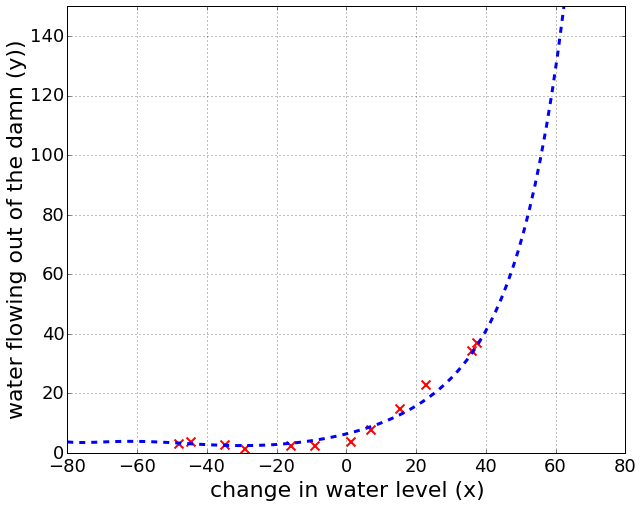

In [123]:
x   = np.linspace(-80,80,100)
p   = np.poly1d(theta_poly_fit[::-1])
plt.scatter(X_train, y_train, color='r', marker='x', s=80, linewidth=2)
plot_fit(x, mu_poly_train, sigma_poly_train, theta_poly_fit, degree)
plt.xlabel("change in water level (x)")
plt.ylabel("water flowing out of the damn (y))")
plt.axis([-80, 80, 0, 150])
plt.grid()
plt.show()

In [124]:
err_train, err_val = learning_err(X_poly_train, y_train, X_poly_val, y_val, lambda_param)

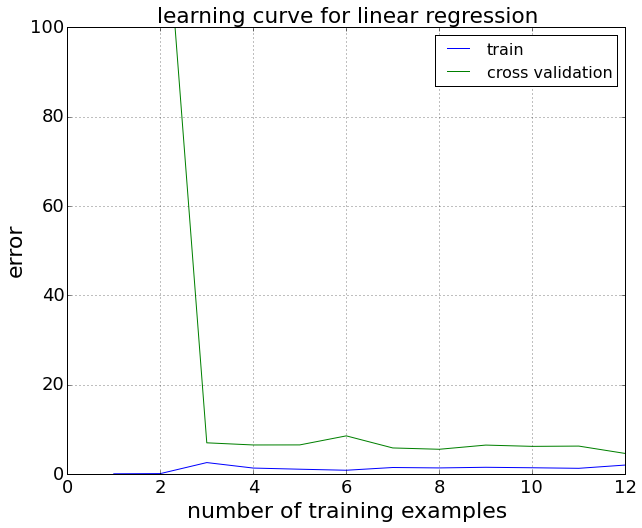

In [125]:
x = np.arange(err_train.size)
plt.plot(x[1:], err_train[1:], x[1:], err_val[1:])
plt.legend(['train', 'cross validation'])
plt.title('learning curve for linear regression')
plt.xlabel("number of training examples")
plt.ylabel("error")
plt.axis([0,12,0,100])
plt.grid()

In [126]:
#### $\lambda = 100$

In [127]:
lambda_param = 100

In [128]:
theta_poly_fit = train_linreg(X_poly_train, y_train, lambda_param=lambda_param, disp=True)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 65.5698080262
            Iterations: 5
            Function evaluations: 11
            Gradient evaluations: 5


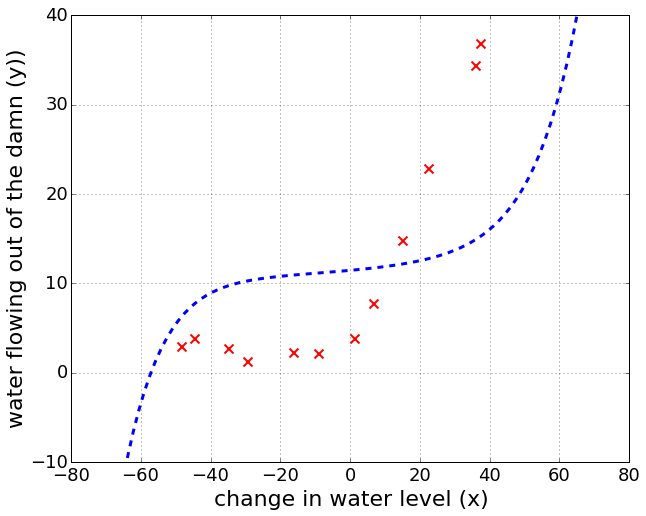

In [129]:
x   = np.linspace(-80,80,100)
p   = np.poly1d(theta_poly_fit[::-1])
plt.scatter(X_train, y_train, color='r', marker='x', s=80, linewidth=2)
plot_fit(x, mu_poly_train, sigma_poly_train, theta_poly_fit, degree)
plt.xlabel("change in water level (x)")
plt.ylabel("water flowing out of the damn (y))")
plt.axis([-80, 80, -10, 40])
plt.grid()
plt.show()

In [130]:
err_train, err_val = learning_err(X_poly_train, y_train, X_poly_val, y_val, lambda_param)

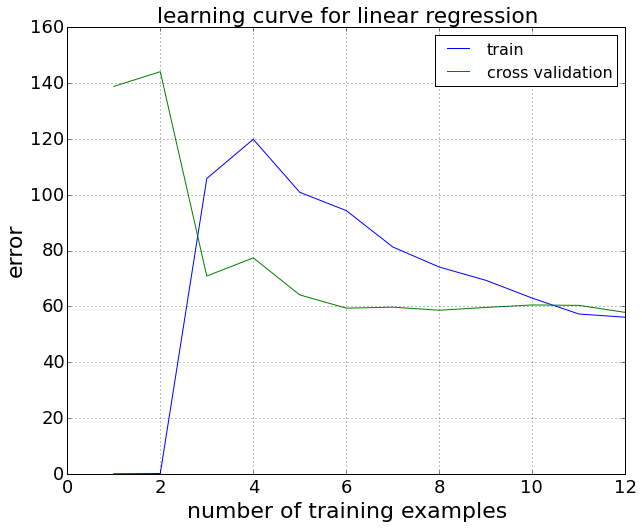

In [131]:
x = np.arange(err_train.size)
plt.plot(x[1:], err_train[1:], x[1:], err_val[1:])
plt.legend(['train', 'cross validation'])
plt.title('learning curve for linear regression')
plt.xlabel("number of training examples")
plt.ylabel("error")
# plt.axis([0,12,0,100])
plt.grid()

### 3.3 Selecting $\lambda$ using a cross validation set

From the previous parts of the exercise, you observed that the value of $\lambda$ can significantly affect the results of regularized polynomial regression on the training and cross validation set. In particular, a model without regularization ($\lambda = 0$) fits the training set well, but does not generalize. Conversely, a model with too much regularization ($\lambda = 100$) does not fitt the training set and testing set well. A good choice of $\lambda$ (e.g., $\lambda$ = 1) can provide a good fit to the data.

In this section, you will implement an automated method to select the fit parameter. Concretely, you will use a cross validation set to evaluate how good each fit value is. After selecting the best fit value using the cross validation set, we can then evaluate the model on the test set to estimate how well the model will perform on actual unseen data.

Your task is to complete the code in validationCurve.m. Specifically, you should should use the `trainLinearReg` function to train the model using different values of $\lambda$ and compute the training error and cross validation error. You should try $\lambda$ in the following range: {0; 0.001; 0.003; 0.01; 0.03; 0.1; 0.3; 1; 3; 10}.


In [132]:
def learning_err_lambda(X_train, y_train, X_val, y_val, lambda_params):
    m, n         = X_train.shape
    err_train    = np.zeros_like(lambda_params)
    err_val      = np.zeros_like(lambda_params)

    for idx, lambda_param in enumerate(lambda_params):
        
        theta = train_linreg(X_train, y_train, lambda_param=lambda_param)

        err_train[idx] = cost(theta, X_train, y_train, lambda_param=0.0)
        err_val[idx]   = cost(theta, X_val  , y_val  , lambda_param=0.0)

    return err_train, err_val

In [133]:
lambda_params = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10])
lambda_params

array([  0.000e+00,   1.000e-03,   3.000e-03,   1.000e-02,   3.000e-02,   1.000e-01,   3.000e-01,   1.000e+00,   3.000e+00,   1.000e+01])

In [134]:
err_train, err_val = learning_err_lambda(X_poly_train, y_train, X_poly_val, y_val, lambda_params)

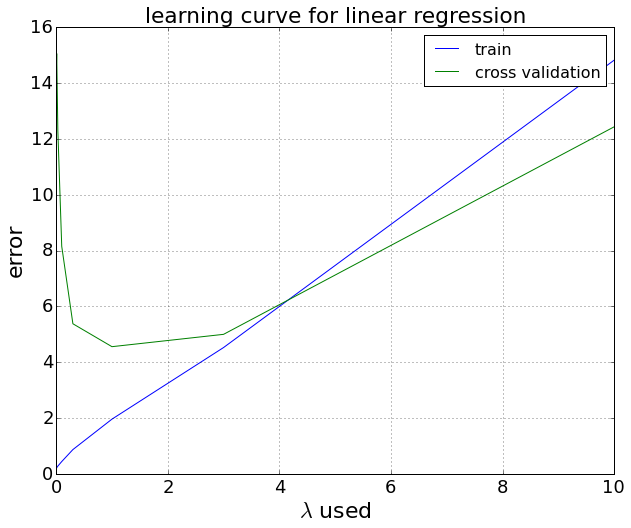

In [135]:
# x = np.arange(err_train.size)
plt.plot(lambda_params, err_train, lambda_params, err_val)
plt.legend(['train', 'cross validation'])
plt.title('learning curve for linear regression')
plt.xlabel(r'$\lambda$ used')
plt.ylabel("error")
# plt.axis([0,12,0,100])
plt.grid()

### 3.4 Computing test set error

In the previous part of the exercise, you implemented code to compute the cross validation error for various values of the regularization parameter $\lambda$. However, to get a better indication of the model's performance in the real
world, it is important to evaluate the "final" model on a test set that was not used in any part of training (that is, it was neither used to select the $\lambda$ parameters, nor to learn the model parameters $\theta$).

For this optional (ungraded) exercise, you should compute the test error using the best value of $\lambda$ you found. In our cross validation, we obtained a test error of 3.8599 for $\lambda = 3$.

In [136]:
def learning_err_test(X_train, y_train, X_test, y_test, lambda_param):
    m, n      = X_train.shape
    theta     = train_linreg(X_train, y_train, lambda_param=float(lambda_param))
    err_train = cost(theta, X_train, y_train, lambda_param=0.0)
    err_test  = cost(theta, X_test , y_test , lambda_param=0.0)
    return err_train, err_test

In [137]:
err_train, err_test = learning_err_test(X_poly_train, y_train, X_poly_test, y_test, lambda_param=1.0)
err_train, err_test

(1.9589546985887409, 7.8513452799426267)

In [138]:
err_train, err_test = learning_err_test(X_poly_train, y_train, X_poly_test, y_test, lambda_param=3.0)
err_train, err_test

(4.5253937405991564, 11.770567212902687)

### 3.5 Plotting learning curves with randomly selected examples

In practice, especially for small training sets, when you plot learning curves to debug your algorithms, it is often helpful to average across multiple sets of randomly selected examples to determine the training error and cross
validation error.

Concretely, to determine the training error and cross validation error for i examples, you should first randomly select i examples from the training set and i examples from the cross validation set. You will then learn the parameters $\theta$ using the randomly chosen training set and evaluate the parameters $\theta$ on the randomly chosen training set and cross validation set. The above steps should then be repeated multiple times (say 50) and the averaged error should be used to determine the training error and cross validation error for i examples.

For this optional (ungraded) exercise, you should implement the above strategy for computing the learning curves. For reference, figure 10 shows the learning curve we obtained for polynomial regression with $\lambda = 0.01$. Your
figure may differ slightly due to the random selection of examples.

In [190]:
def learning_err_random(X_train, y_train, X_val, y_val, n_rand=1000, lambda_param=0.0):
    m, n      = X_train.shape
    err_train = np.zeros((m+1,n_rand))
    err_val   = np.zeros((m+1,n_rand))
    for i in np.arange(1,m+1):
        for n in np.arange(n_rand):            
#             np.random.seed(n*i)
            random_idx = np.random.choice(np.arange(m), i)
            X = X_train[random_idx,...]
            y = y_train[random_idx]

            theta = train_linreg(X, y, lambda_param=lambda_param)

            err_train[i, n] = cost(theta, X    , y    , lambda_param=0.0)
            err_val  [i, n] = cost(theta, X_val, y_val, lambda_param=0.0)

    return np.mean(err_train, axis=1), np.std(err_train, axis=1), np.mean(err_val, axis=1), np.std(err_val, axis=1)

In [191]:
err_train, std_train, err_val, std_val = learning_err_random(X_poly_train, y_train, X_poly_val, y_val, n_rand=2, lambda_param=0.01)

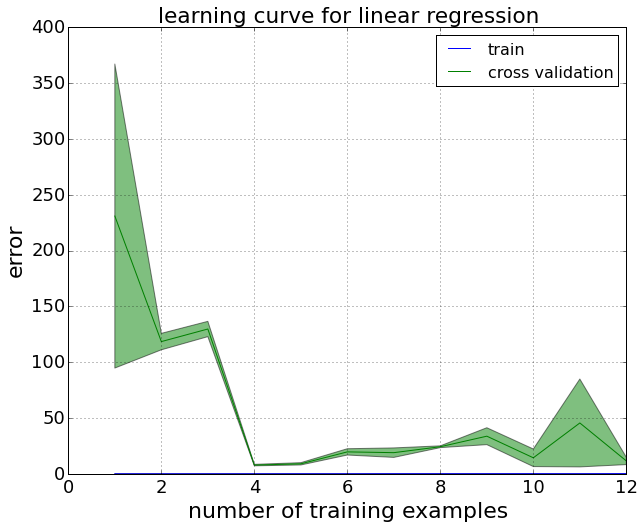

In [192]:
x = np.arange(err_train.size)
plt.plot(x[1:], err_train[1:], x[1:], err_val[1:])
plt.fill_between(x[1:], err_train[1:]+std_train[1:], err_train[1:]-std_train[1:], facecolor='blue' , alpha=0.5)
plt.fill_between(x[1:], err_val  [1:]+std_val  [1:], err_val  [1:]-std_val  [1:], facecolor='green', alpha=0.5)
plt.legend(['train', 'cross validation'])
plt.title('learning curve for linear regression')
plt.xlabel("number of training examples")
plt.ylabel("error")
# plt.axis([0,12,0,100])
plt.grid()